# Robotic Systems II (ECE-DK904)

## Electrical and Computer Engineering Department, University of Patras, Greece

**Instructor:** Konstantinos Chatzilygeroudis (costashatz@upatras.gr)

## Lab 7

### Linearization over a trajectory

#### Pendulum System

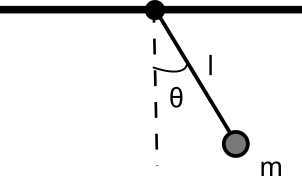

$\boldsymbol{x} = \begin{bmatrix}\theta\\\dot{\theta}\end{bmatrix}$

$\boldsymbol{u} = \tau\in\mathbb{R}$

$\dot{\boldsymbol{x}} = \begin{bmatrix}\dot{\theta}\\\frac{-g}{l}\text{sin}\theta+\frac{1}{ml^2}\boldsymbol{u}-b\dot{\theta}\end{bmatrix}$

where $g$ is the gravity, $b$ is the joint friction, $l$ is the length of the pendulum pole and $m$ is the mass of the tip of the pole.

#### Task

We are going to linearize the system over a trajectory and not over a fixed point (as were doing in the previous labs/lectures). Let's start by writing down the dynamics and jacobians:

In [ ]:
import numpy as np # Linear Algebra
import matplotlib.pyplot as plt # Plotting

In [ ]:
# We start by writing the dynamics
def pendulum(x, u, g = 9.81, l = 1., m = 1., b = 0.):
    x_dot = np.concatenate([x[1:], -(g/l)*np.sin(x[:1]) + 1./(m*l*l)*u - b*x[1:]], axis=0)
    return x_dot

# And the Jacobians
def pendulum_dx(x, u, g = 9.81, l = 1., m = 1., b = 0.):
    ### TO-DO: Write the Jacobian df/dx
    jac = np.block([[           0.        , 1.],
                    [-g/l * np.cos(x[:1]), -b]])
    ### END of TO-DO
    return jac

def pendulum_du(x, u, g = 9.81, l = 1., m = 1., b = 0.):
    ### TO-DO: Write the Jacobian df/du
    jac = np.array([[      0.      ],
                    [1 / (l * m**2)]])
    ### END of TO-D
    return jac

# Let's evaluate the jacobians with finite differences
def finite_diff(f, z, M, eps = 1e-6):
    N = z.shape[0]
    jac = np.zeros((M, N))
    for i in range(N):
        zp = np.copy(z)
        zp[i] += eps
        zm = np.copy(z)
        zm[i] -= eps
        jac[:, i:i+1] = (f(zp) - f(zm)) / (2. * eps)
    return jac

# Let's check if the jacobians are correct
# Change those two to check that they are always the same!
x0 = np.array([[5.], [-10.]])
u0 = np.array([[2.]])

fx = lambda z : pendulum(z, u0)
fu = lambda z : pendulum(x0, z)

dpdx = pendulum_dx(x0, u0)
dpdx_finite = finite_diff(fx, x0, 2)

dpdu = pendulum_du(x0, u0)
dpdu_finite = finite_diff(fu, u0, 2)

print("Jacobian dx:")
print("Analytical:\n", dpdx)
print("Finite diff:\n", dpdx_finite)
print("Difference:", np.linalg.norm(dpdx-dpdx_finite))

print("Jacobian du:")
print("Analytical:\n", dpdu)
print("Finite diff:\n", dpdu_finite)
print("Difference:", np.linalg.norm(dpdu-dpdu_finite))

Now let's write down an RK4 integrator and the associated jacobians:

In [ ]:
# RK4 Integration
def pendulum_rk4(x, u, dt = 0.05):
    f1 = pendulum(x, u)
    f2 = pendulum(x + 0.5 * dt * f1, u)
    f3 = pendulum(x + 0.5 * dt * f2, u)
    f4 = pendulum(x + dt * f3, u)
    x_n = x + (dt/6.)*(f1 + 2. * f2 + 2. * f3 + f4)
    return x_n

# RK4 Jacobian dx
def pendulum_rk4_dx(x, u, dt = 0.05):
    ### TO-DO: Write Jacobian df/dx
    x2 = x + 0.5 * dt * pendulum(x, u)
    x3 = x + 0.5 * dt * pendulum(x2, u)
    x4 = x + dt * pendulum(x3, u)

    dfdx = pendulum_dx(x, u)
    dfdx2 = pendulum_dx(x2, u)
    dfdx3 = pendulum_dx(x3, u)
    dfdx4 = pendulum_dx(x4, u)
    
    dx2dx = np.eye(2) + 0.5 * dt * dfdx
    dx3dx = np.eye(2) + 0.5 * dt * dfdx2 @ dx2dx
    dx4dx = np.eye(2) + dt * dfdx3 @ dx3dx
    
    return np.eye(2) + dt/6. * (dfdx + 2. * dfdx2 @ dx2dx + 2. * dfdx3 @ dx3dx + dfdx4 @ dx4dx)
    ### END of TO_DO

# RK4 Jacobian du
def pendulum_rk4_du(x, u, dt = 0.05):
    ### TO-DO: Write Jacobian df/du
    x2 = x + 0.5 * dt * pendulum(x, u)
    x3 = x + 0.5 * dt * pendulum(x2, u)
    x4 = x + dt * pendulum(x3, u)

    dfdx = pendulum_dx(x, u)
    dfdx2 = pendulum_dx(x2, u)
    dfdx3 = pendulum_dx(x3, u)
    dfdx4 = pendulum_dx(x4, u)
    dfdu = pendulum_du(x, u)
    dfdu2 = pendulum_du(x2, u)
    dfdu3 = pendulum_du(x3, u)
    dfdu4 = pendulum_du(x4, u)

    dx2dx = np.eye(2) + 0.5 * dt * dfdx
    dx3dx = np.eye(2) + 0.5 * dt * dfdx2 @ dx2dx
    dx4dx = np.eye(2) + dt * dfdx3 @ dx3dx
    dx2du = 0.5 * dt * dfdu
    dx3du = 0.5 * dt * (dfdu2 + dfdx2 @ dx2du)
    dx4du = dt * (dfdu3 + dfdx3 @ dx3du)
    
    return dt/6. * (dfdu + 2 * (dfdu2 + dfdx2 @ dx2du) + 2 * (dfdu3 + dfdx3 @ dx3du) + (dfdu4 + dfdx4 @ dx4du))
    ### END of TO-DO

# Check if Jacobians are correct
# Change those two to check that they are always the same!
x0 = np.array([[2.], [-3.]])
u0 = np.array([[2.]])

fx = lambda z : pendulum_rk4(z, u0)
fu = lambda z : pendulum_rk4(x0, z)

dpdx = pendulum_rk4_dx(x0, u0)
dpdx_finite = finite_diff(fx, x0, 2)

dpdu = pendulum_rk4_du(x0, u0)
dpdu_finite = finite_diff(fu, u0, 2)

print("Jacobian dx:")
print(dpdx)
print("Jacobian dx (finite):")
print(dpdx_finite)
print("Difference:", np.linalg.norm(dpdx-dpdx_finite))

print("Jacobian du:")
print(dpdu)
print("Jacobian du (finite):")
print(dpdu_finite)
print("Difference:", np.linalg.norm(dpdu-dpdu_finite))

Now we should generate a trajectory to linearize over. We will use a simple PD controller to do so.

In [ ]:
# Duration, steps and time step
dt = 0.05
tf = 10.
K = round(tf/dt) + 1
print("K =", K)

# Controller
Kp = np.diag([12., 3.]) # np.diag([1.2, 0.4])

# Target
x_ref = np.array([[np.pi, 0.]]).T

# Let's simulate
x0 = np.zeros((2, 1))
states = [x0]
actions = []

x = np.copy(x0)
for _ in range(K):
    u = np.array([[np.sum(Kp * (x_ref - x))]])
    x = pendulum_rk4(x, u)
    states.append(np.copy(x))
    actions.append(np.copy(u))
print(states[-1])

In [ ]:
# Let's plot the trajectory
fig = plt.figure()  # no frame
ax = fig.add_subplot(1, 1, 1)

ax.plot([k * dt for k in range(K)], [states[k][0, 0] for k in range(K)], label="position")
ax.plot([k * dt for k in range(K)], [states[k][1, 0] for k in range(K)], label="velocity")

plt.xlabel("Time")

plt.legend();

Now let's do the actual linearization. We $K$ steps and thus we need $K-1$ $\boldsymbol{A}$ and $\boldsymbol{B}$ matrices. Let's compute them:

In [ ]:
# Dimensions of the problem
N = 2 # state
M = 1 # action

# Placeholders (arrays) for the A and B matrices
A = [np.zeros((N, N))]*(K-1)
B = [np.zeros((N, M))]*(K-1)

for k in range(K-1):
    ### TO-DO: Calculate the A and B matrices
    A[k] = pendulum_rk4_dx(states[k], actions[k])
    B[k] = pendulum_rk4_du(states[k],actions[k])
    ### END of TO-DO

In [ ]:
# Let's visualize the linearization
# First let's compute some values
k = 5 # pick which time step we want to visualize the linearization over

t = [k * dt]
xs = [np.copy(states[k])]

steps = 5
x = np.copy(states[k])
for i in range(steps):
    t.append(k * dt + (i + 1) *dt)
    x = states[k+1] + A[k] @ (x - states[k])
    xs.append(np.copy(x))

# Now let's plot!
fig = plt.figure()  # no frame
ax = fig.add_subplot(1, 1, 1)

# Plot actual function
ax.plot([i * dt for i in range(K)], [states[i][0, 0] for i in range(K)], label="position")
ax.plot([i * dt for i in range(K)], [states[i][1, 0] for i in range(K)], label="velocity")

# Plot linearization
ax.plot(t, [xs[i][0, 0] for i in range(len(xs))], linewidth=3, color="green", label="linearization (position)")
ax.plot(t, [xs[i][1, 0] for i in range(len(xs))], linewidth=3, color="purple", label="linearization (velocity)")

plt.xlabel("Time")

plt.legend();

Now let's do Time Variant LQR:

In [ ]:
# Cost
Q = np.eye(N)
R = 0.01 * np.eye(M)
QN = np.eye(N)

# Init
Ps = [np.zeros((N, N))]*K
Ks = [np.zeros((M, N))]*(K-1)

# Riccati backward
Ps[K-1] = QN
for k in range(K-2, -1, -1):
    ### TO-DO: Write the Riccati recursion for the time variant LQR
    lhs = (R + B[k].T @ Ps[k+1] @ B[k])
    rhs = B[k].T @ Ps[k+1] @ A[k]
    Ks[k] = np.linalg.solve(lhs, rhs)
    Ps[k] = Q + Ks[k].T @ R @ Ks[k] + (A[k] - B[k] @ Ks[k]).T @ Ps[k+1] @ (A[k] - B[k] @ Ks[k])
    ### END of TO-DO

In [ ]:
# Let's simulate with the LQR controller and add noise!
x0 = np.zeros((N, 1))
xs = [np.copy(x0)]
us = []

# noise epsilon
noise = 1e-1

x = np.copy(x0)
for k in range(K-1):
    x_pertubation = np.random.uniform(-noise, noise, size=(N,1))
    xp = np.copy(x) + x_pertubation
    u = np.copy(actions[k]) - Ks[k] @ (xp - states[k])
    x = pendulum_rk4(xp, u)
    xs.append(np.copy(xp))
    us.append(np.copy(u))
print(xs[-1])

In [ ]:
# Let's plot the trajectory
fig = plt.figure()  # no frame
ax = fig.add_subplot(1, 1, 1)

ax.plot([k * dt for k in range(K)], [xs[k][0, 0] for k in range(K)], label="position")
ax.plot([k * dt for k in range(K)], [xs[k][1, 0] for k in range(K)], label="velocity")

plt.xlabel("Time")

plt.legend();